# 0716230 陳子睿

# 1. DATA INPUT

In [130]:
import numpy as np
import pandas as pd
import seaborn as sns
import csv
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

d1=pd.read_csv("student-mat.csv",sep=";")
df_original = pd.DataFrame(data=d1)
df_original.columns = ['school','sex','age','address','family_size','parents_status','mother_education','father_education',
'mother_job','father_job','reason','guardian','commute_time','study_time','failures','school_support','family_support','paid_classes','activities','nursery','desire_higher_edu','internet','romantic','family_quality',
'free_time','go_out','weekday_alcohol_usage','weekend_alcohol_usage','health','absences','period1_score','period2_score','final_score']
df=df_original
df_binary=df_original
#df_original.head(10)


### code explain

load csv file <br>
change the data's column to what you want <br>
make the data into two dataframe (binary data and five level data) <br>
store the original data at df_original


# 2. DATA PREPROCESSING

## Transform data format and shape so your model can process them

In [131]:
df = pd.get_dummies(df)
df_binary = pd.get_dummies(df_binary)

### code explain
use panda.get_dummies to turn categorical features to numerical features

## Shuffle data

In [132]:
from sklearn.utils import shuffle
df = shuffle(df , random_state=1)
df_binary = shuffle(df_binary , random_state=1)



### code explain
use shuffle function to randomly shuffle the data

## Transform label format so you can do the required two tasks described below Data section.

In [133]:
# convert final_score to categorical variable 
# A 16-20 B:14-15 C:12-13 D 10-11  F:0~9
df.loc[(df.final_score >= 16) & (df.final_score <= 20), 'final_grade'] = 'A' 
df.loc[(df.final_score >= 14) & (df.final_score <= 15), 'final_grade'] = 'B' 
df.loc[(df.final_score >= 12) & (df.final_score <= 13), 'final_grade'] = 'C' 
df.loc[(df.final_score >= 10) & (df.final_score <= 11), 'final_grade'] = 'D' 
df.loc[(df.final_score >= 0) & (df.final_score <= 9), 'final_grade'] = 'F'

# convert final_score(G3) to classification
df_binary['final_grade'] = 'fail'
df_binary.loc[(df_binary.final_score >= 10), 'final_grade'] = 'pass'
df.head(10)

df = df.drop(columns=['final_score'])
df_binary = df_binary.drop(columns=['final_score'])

#df['final_grade'].head(10)


### code explain 
change five level data's final grade to five levels A,B,C,D,F (according to their final_score)<br>
change binary level data's final grade to binary levels pass and fail (according to their final_score)<br>

# 3. MODEL CONSTRUCTION

## construct decision tree

In [134]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
#from id3 import Id3Estimator
#estimator = Id3Estimator( min_samples_split=13)


from sklearn.tree import DecisionTreeClassifier
estimator = DecisionTreeClassifier(criterion='gini',min_samples_leaf=17)

### code explain 

***Decision tree algorithm :*** the sklearn Desicion Tree classifier use an optimised version of the CART algorithm. This algorithm is very similiar to id3 algorithm but use gini as criterion. The decision rule of CART is same as id3, however, the main difference between CART and ID3 is that it supports numerical target variables (regression) and does not compute rule sets. CART constructs binary trees, namely each internal node has exactly two outgoing edges, using the feature and threshold that yields the largest information gain at each node. I also specify the min_samples_leaf to avoid overfitting.



## construct random forest (with three different numbers of trees)

In [135]:
from sklearn.ensemble import RandomForestClassifier
forest1 = RandomForestClassifier(n_estimators=10, max_depth=7,oob_score=True)
forest2 = RandomForestClassifier(n_estimators=20, max_depth=7,oob_score=True)
forest3 = RandomForestClassifier(n_estimators=100, max_depth=7,oob_score=True)

### Data selection : both randomly select samples and features done by sklearn module
The sklearn module will use bootstrap sampling and will ***randomly select both samples and features***
<br><br>
### Comparing result between three trees
Random forest model will get better accuracy if n_estimator is larger (in theory). However, when constructing the random forest model, we should specify a not to big max_depth to avoid overfitting. In most condition, when n is larger, the accuracy is the better but also more time-consuming.
<br><br>

### Understand the difference between K-fold cross-validation and Random Forest. 
K-fold cross validation works by breaking your training data into K equal-sized folds.And then it iterates through each fold, treating that fold as holdout data, and other K-1 folds as training data. Eventually evaluating ***using the same model’s*** performance on the one holdout fold.

Random Forest select k data instances form m data(m>>k), and construct ***many decision tree (model) for each k data***. When testing data, these models use voting to decide their final result
<br><br>
### Code explain
use sklearn RandomForestClassifier to construct the model.
oob_score=True means that we will also use out of bag error (construct data that aren't selected to become a tree)
specify max_depth to avoid overfitting.(Chapter 2 p.40)
n_estimator means how many trees will be generate (it will select data by Bootstrap sample with replacement Chapter 2 p.40)<br>
bootstrap=True (default), use bootstrap sampling.

## construct KNN

In [136]:
from sklearn import preprocessing

normalized_df = preprocessing.normalize(df.iloc[:,:58])
normalized_df_binary = preprocessing.normalize(df_binary.iloc[:,:58])

X_norm = normalized_df[ : ,:58]

from sklearn.neighbors import KNeighborsClassifier
neigh1 = KNeighborsClassifier(n_neighbors=5,weights='distance')
neigh2 = KNeighborsClassifier(n_neighbors=10,weights='distance')
neigh3 = KNeighborsClassifier(n_neighbors=100,weights='distance')

### compare three models with different K value
KNN model's accuracy will vary with K, because when K is larger the influence of noise data and important data will be lower. G1 and G2 are data that are very closely relate to G3, thus when K is very big, the accuracy will be lower. However, if I drop G1,G2, the accuracy may be better when K is larger. In conclusion , the best K is not always the largest one.
<br><br>

### code explain
I use sklearn preprocessing to normalize data frame. And then use sklearn KNeighborsClassifier to construct models.
n_neighbors is the value of K, weights='distance' means that when caculating K nearest neighbors, we will consider its distance of each node.




# 4. VALIDATION

## Holdout validation (five level)

In [137]:
# split the data into feature 1-58 columns and output column
X_five_class = df.iloc[:,:58].values   
Y_five_class = df['final_grade'].values

# hold out splitting data into 70% training and 30% test data: 
# test_size is the ratio
X_five_train, X_five_test, y_five_train, y_five_test = train_test_split(X_five_class, Y_five_class, test_size=0.3, random_state=1) 

## K-Fold validation (five level)

In [138]:
X_five_train_list = []
Y_five_train_list = []
X_five_test_list = []
Y_five_test_list = []

# K-fold cross-validation
from sklearn.model_selection import KFold
cv = KFold(n_splits=3 , random_state=1, shuffle=True)

for train_index, test_index in cv.split(X_five_class, Y_five_class):
    X_five_train_list.append(X_five_class[train_index])
    X_five_test_list.append(X_five_class[test_index])
    Y_five_train_list.append(Y_five_class[train_index])
    Y_five_test_list.append(Y_five_class[test_index])


## Holdout validation (binary class)

In [139]:
# split the data into feature 1-58 columns and output column
X_binary = df_binary.iloc[:,:58].values   
Y_binary = df_binary['final_grade'].values

# hold out splitting data into 70% training and 30% test data: 
# test_size is the ratio
X_binary_train, X_binary_test, y_binary_train, y_binary_test = train_test_split(X_binary, Y_binary, test_size=0.3, random_state=1) 


## K-Fold validation (binary class)

In [140]:
X_binary_train_list = []
Y_binary_train_list = []
X_binary_test_list = []
Y_binary_test_list = []

# K-fold cross-validation
from sklearn.model_selection import KFold
cv = KFold(n_splits=3 , random_state=1, shuffle=True)

for train_index, test_index in cv.split(X_binary, Y_binary):
    X_binary_train_list.append(X_binary[train_index])
    X_binary_test_list.append(X_binary[test_index])
    Y_binary_train_list.append(Y_binary[train_index])
    Y_binary_test_list.append(Y_binary[test_index])

### code explain

Split the data into conditional test and train data and result train and test data

Hold out validation : import train_test_split to split the data<br>
test_size=0.3 means that after splitting,(test size/all size) = 0.3. Which is equal to (train_size : test_size) = 7:3<br>
<br>
K-Fold validation : import KFold to split the data, and then use for loop to append those data into train_list and test_list.<br>
Do the exactly same thing on both five level and binary level data.

# 5. RESULT

## Decision-Tree Hold-out result (binary class)

In [141]:
from sklearn.metrics import recall_score

estimator.fit(X_binary_train,y_binary_train)
y_binary_pred = estimator.predict(X_binary_test)
pre = precision_score(y_binary_test, y_binary_pred, average='micro')
acc = accuracy_score(y_binary_test, y_binary_pred)
cm = confusion_matrix(y_binary_test, y_binary_pred)
recall = recall_score(y_binary_test, y_binary_pred, average='macro')

print(cm)
print("\n")
print('Hold out splitting Accuracy : {:.4f}'.format(acc))
print('Hold out splitting Precision : {:.4f}'.format(pre))
print('Hold out splitting Sensitivity : {:.4f}'.format(recall))
print("\n")
print(classification_report(y_binary_test, y_binary_pred))

[[44  3]
 [ 7 65]]


Hold out splitting Accuracy : 0.9160
Hold out splitting Precision : 0.9160
Hold out splitting Sensitivity : 0.9195


              precision    recall  f1-score   support

        fail       0.86      0.94      0.90        47
        pass       0.96      0.90      0.93        72

    accuracy                           0.92       119
   macro avg       0.91      0.92      0.91       119
weighted avg       0.92      0.92      0.92       119



## Random-Forest forest1 Hold-out result (binary class)

In [142]:
from sklearn.metrics import recall_score

forest1.fit(X_binary_train,y_binary_train)
y_binary_pred = forest1.predict(X_binary_test)
pre = precision_score(y_binary_test, y_binary_pred, average='micro')
acc = accuracy_score(y_binary_test, y_binary_pred)
cm = confusion_matrix(y_binary_test, y_binary_pred)
recall = recall_score(y_binary_test, y_binary_pred, average='macro')

print(cm)
print("\n")
print('Hold out splitting Accuracy : {:.4f}'.format(acc))
print('Hold out splitting Precision : {:.4f}'.format(pre))
print('Hold out splitting Sensitivity : {:.4f}'.format(recall))
print("\n")
print(classification_report(y_binary_test, y_binary_pred))

[[39  8]
 [ 2 70]]


Hold out splitting Accuracy : 0.9160
Hold out splitting Precision : 0.9160
Hold out splitting Sensitivity : 0.9010


              precision    recall  f1-score   support

        fail       0.95      0.83      0.89        47
        pass       0.90      0.97      0.93        72

    accuracy                           0.92       119
   macro avg       0.92      0.90      0.91       119
weighted avg       0.92      0.92      0.91       119



## Random-Forest forest2 Hold-out result (binary class)

In [143]:
forest2.fit(X_binary_train,y_binary_train)
y_binary_pred = forest2.predict(X_binary_test)
pre = precision_score(y_binary_test, y_binary_pred, average='micro')
acc = accuracy_score(y_binary_test, y_binary_pred)
cm = confusion_matrix(y_binary_test, y_binary_pred)
recall = recall_score(y_binary_test, y_binary_pred, average='macro')

print(cm)
print("\n")
print('Hold out splitting Accuracy : {:.4f}'.format(acc))
print('Hold out splitting Precision : {:.4f}'.format(pre))
print('Hold out splitting Sensitivity : {:.4f}'.format(recall))
print("\n")
print(classification_report(y_binary_test, y_binary_pred))

[[38  9]
 [ 3 69]]


Hold out splitting Accuracy : 0.8992
Hold out splitting Precision : 0.8992
Hold out splitting Sensitivity : 0.8834


              precision    recall  f1-score   support

        fail       0.93      0.81      0.86        47
        pass       0.88      0.96      0.92        72

    accuracy                           0.90       119
   macro avg       0.91      0.88      0.89       119
weighted avg       0.90      0.90      0.90       119



## Random-Forest forest3 Hold-out result (binary class)

In [144]:
forest3.fit(X_binary_train,y_binary_train)
y_binary_pred = forest3.predict(X_binary_test)
pre = precision_score(y_binary_test, y_binary_pred, average='micro')
acc = accuracy_score(y_binary_test, y_binary_pred)
cm = confusion_matrix(y_binary_test, y_binary_pred)
recall = recall_score(y_binary_test, y_binary_pred, average='macro')

print(cm)
print("\n")
print('Hold out splitting Accuracy : {:.4f}'.format(acc))
print('Hold out splitting Precision : {:.4f}'.format(pre))
print('Hold out splitting Sensitivity : {:.4f}'.format(recall))
print("\n")
print(classification_report(y_binary_test, y_binary_pred))

[[37 10]
 [ 4 68]]


Hold out splitting Accuracy : 0.8824
Hold out splitting Precision : 0.8824
Hold out splitting Sensitivity : 0.8658


              precision    recall  f1-score   support

        fail       0.90      0.79      0.84        47
        pass       0.87      0.94      0.91        72

    accuracy                           0.88       119
   macro avg       0.89      0.87      0.87       119
weighted avg       0.88      0.88      0.88       119



## KNN neigh1 Hold out validation result (binary)

In [145]:
from sklearn import preprocessing
# normalize
X_norm_train = preprocessing.normalize(X_binary_train)
X_norm_test = preprocessing.normalize(X_binary_test)


neigh1.fit(X_norm_train,y_binary_train)
y_binary_pred = neigh1.predict(X_norm_test)
pre = precision_score(y_binary_test, y_binary_pred, average='micro')
acc = accuracy_score(y_binary_test, y_binary_pred)
cm = confusion_matrix(y_binary_test, y_binary_pred)
recall = recall_score(y_binary_test, y_binary_pred, average='macro')

print(cm)
print("\n")
print('Hold out splitting Accuracy : {:.4f}'.format(acc))
print('Hold out splitting Precision : {:.4f}'.format(pre))
print('Hold out splitting Sensitivity : {:.4f}'.format(recall))
print("\n")
print(classification_report(y_binary_test, y_binary_pred))



[[33 14]
 [ 4 68]]


Hold out splitting Accuracy : 0.8487
Hold out splitting Precision : 0.8487
Hold out splitting Sensitivity : 0.8233


              precision    recall  f1-score   support

        fail       0.89      0.70      0.79        47
        pass       0.83      0.94      0.88        72

    accuracy                           0.85       119
   macro avg       0.86      0.82      0.83       119
weighted avg       0.85      0.85      0.84       119



## KNN neigh2 Hold out validation result (binary)

In [146]:
# normalize
X_norm_train = preprocessing.normalize(X_binary_train)
X_norm_test = preprocessing.normalize(X_binary_test)


neigh2.fit(X_norm_train,y_binary_train)
y_binary_pred = neigh2.predict(X_norm_test)
pre = precision_score(y_binary_test, y_binary_pred, average='micro')
acc = accuracy_score(y_binary_test, y_binary_pred)
cm = confusion_matrix(y_binary_test, y_binary_pred)
recall = recall_score(y_binary_test, y_binary_pred, average='macro')

print(cm)
print("\n")
print('Hold out splitting Accuracy : {:.4f}'.format(acc))
print('Hold out splitting Precision : {:.4f}'.format(pre))
print('Hold out splitting Sensitivity : {:.4f}'.format(recall))
print("\n")
print(classification_report(y_binary_test, y_binary_pred))


[[36 11]
 [ 4 68]]


Hold out splitting Accuracy : 0.8739
Hold out splitting Precision : 0.8739
Hold out splitting Sensitivity : 0.8552


              precision    recall  f1-score   support

        fail       0.90      0.77      0.83        47
        pass       0.86      0.94      0.90        72

    accuracy                           0.87       119
   macro avg       0.88      0.86      0.86       119
weighted avg       0.88      0.87      0.87       119



## KNN neigh3 Hold out validation result (binary)

In [147]:
# normalize
X_norm_train = preprocessing.normalize(X_binary_train)
X_norm_test = preprocessing.normalize(X_binary_test)


neigh3.fit(X_norm_train,y_binary_train)
y_binary_pred = neigh3.predict(X_norm_test)
pre = precision_score(y_binary_test, y_binary_pred, average='micro')
acc = accuracy_score(y_binary_test, y_binary_pred)
cm = confusion_matrix(y_binary_test, y_binary_pred)
recall = recall_score(y_binary_test, y_binary_pred, average='macro')

print(cm)
print("\n")
print('Hold out splitting Accuracy : {:.4f}'.format(acc))
print('Hold out splitting Precision : {:.4f}'.format(pre))
print('Hold out splitting Sensitivity : {:.4f}'.format(recall))
print("\n")
print(classification_report(y_binary_test, y_binary_pred))


[[ 9 38]
 [ 0 72]]


Hold out splitting Accuracy : 0.6807
Hold out splitting Precision : 0.6807
Hold out splitting Sensitivity : 0.5957


              precision    recall  f1-score   support

        fail       1.00      0.19      0.32        47
        pass       0.65      1.00      0.79        72

    accuracy                           0.68       119
   macro avg       0.83      0.60      0.56       119
weighted avg       0.79      0.68      0.61       119



### code explain for above 7 seven result

choose the model you want (forest, estimator , neigh)

X_norm_train = preprocessing.normalize(X_binary_train) --> normalize train data
X_norm_test = preprocessing.normalize(X_binary_test) --> normalize test data
model.fit(X_train, y_train) --> use train data to fit the data <br>
y_pred = model.predict(X_test) --> predict y_pred by getting X-test <br>
then compare y_test(result) with y_pred (predict result) <br>
precision_score(y_test, y_pred)--> get precision <br>
accuracy_score(y_test, y_pred) --> get accuracy <br>
confusion_matrix(y_test, y_pred) --> get confusion matrix <br>
recall_score(y_test, y_pred, average='macro') --> get sensitivity <br>


## Decision-Tree K-Fold validation result (binary)

In [148]:
accuracy = 0
precision = 0
recall = 0

for i in range(3):

    estimator.fit(X_binary_train_list[i], Y_binary_train_list[i])
    y_binary_pred = estimator.predict(X_binary_test_list[i]) 
    precision += precision_score(Y_binary_test_list[i], y_binary_pred, average='macro')
    accuracy += accuracy_score(Y_binary_test_list[i], y_binary_pred)
    recall += recall_score(Y_binary_test_list[i], y_binary_pred, average='macro')
    cm = confusion_matrix(Y_binary_test_list[i], y_binary_pred)
    print(cm)
    print("\n")

print('K-FOLD splitting Accuracy : {:.4f}'.format(accuracy/3))
print('K-FOLD splitting Precision : {:.4f}'.format(precision/3))
print('K-FOLD splitting Sensitivity  : {:.4f}'.format(recall/3))
from sklearn.model_selection import cross_val_predict
score = cross_val_predict(estimator, X_binary, Y_binary, cv=cv)
score.shape
print(classification_report(Y_binary, score))
print("\n")

[[52  3]
 [ 7 70]]


[[32  7]
 [ 3 90]]


[[36  0]
 [11 84]]


K-FOLD splitting Accuracy : 0.9215
K-FOLD splitting Precision : 0.9081
K-FOLD splitting Sensitivity  : 0.9212
              precision    recall  f1-score   support

        fail       0.85      0.92      0.89       130
        pass       0.96      0.92      0.94       265

    accuracy                           0.92       395
   macro avg       0.91      0.92      0.91       395
weighted avg       0.92      0.92      0.92       395





## Random-Forest forest1 K-Fold result (binary class)

In [149]:
accuracy = 0
precision = 0
recall = 0

for i in range(3):

    forest1.fit(X_binary_train_list[i], Y_binary_train_list[i])
    y_binary_pred = forest1.predict(X_binary_test_list[i]) 
    precision += precision_score(Y_binary_test_list[i], y_binary_pred, average='macro')
    accuracy += accuracy_score(Y_binary_test_list[i], y_binary_pred)
    recall += recall_score(Y_binary_test_list[i], y_binary_pred, average='macro')
    cm = confusion_matrix(Y_binary_test_list[i], y_binary_pred)
    print(cm)
    print("\n")

print('K-FOLD splitting Accuracy : {:.4f}'.format(accuracy/3))
print('K-FOLD splitting Precision : {:.4f}'.format(precision/3))
print('K-FOLD splitting Sensitivity  : {:.4f}'.format(recall/3))
from sklearn.model_selection import cross_val_predict
score = cross_val_predict(forest1, X_binary, Y_binary, cv=cv)
score.shape
print(classification_report(Y_binary, score))
print("\n")

[[42 13]
 [ 3 74]]


[[27 12]
 [ 5 88]]


[[33  3]
 [15 80]]


K-FOLD splitting Accuracy : 0.8709
K-FOLD splitting Precision : 0.8598
K-FOLD splitting Sensitivity  : 0.8537
              precision    recall  f1-score   support

        fail       0.82      0.75      0.78       130
        pass       0.88      0.92      0.90       265

    accuracy                           0.86       395
   macro avg       0.85      0.83      0.84       395
weighted avg       0.86      0.86      0.86       395





## Random-Forest forest2 K-Fold result (binary class)

In [150]:
accuracy = 0
precision = 0
recall = 0

for i in range(3):

    forest2.fit(X_binary_train_list[i], Y_binary_train_list[i])
    y_binary_pred = forest2.predict(X_binary_test_list[i]) 
    precision += precision_score(Y_binary_test_list[i], y_binary_pred, average='macro')
    accuracy += accuracy_score(Y_binary_test_list[i], y_binary_pred)
    recall += recall_score(Y_binary_test_list[i], y_binary_pred, average='macro')
    cm = confusion_matrix(Y_binary_test_list[i], y_binary_pred)
    print(cm)
    print("\n")

print('K-FOLD splitting Accuracy : {:.4f}'.format(accuracy/3))
print('K-FOLD splitting Precision : {:.4f}'.format(precision/3))
print('K-FOLD splitting Sensitivity  : {:.4f}'.format(recall/3))
from sklearn.model_selection import cross_val_predict
score = cross_val_predict(forest2, X_binary, Y_binary, cv=cv)
score.shape
print(classification_report(Y_binary, score))
print("\n")

[[40 15]
 [ 4 73]]


[[29 10]
 [ 5 88]]


[[33  3]
 [ 9 86]]


K-FOLD splitting Accuracy : 0.8836
K-FOLD splitting Precision : 0.8736
K-FOLD splitting Sensitivity  : 0.8645
              precision    recall  f1-score   support

        fail       0.85      0.85      0.85       130
        pass       0.92      0.92      0.92       265

    accuracy                           0.90       395
   macro avg       0.89      0.89      0.89       395
weighted avg       0.90      0.90      0.90       395





## Random-Forest forest3 K-Fold result (binary class)

In [151]:
accuracy = 0
precision = 0
recall = 0

for i in range(3):

    forest3.fit(X_binary_train_list[i], Y_binary_train_list[i])
    y_binary_pred = forest3.predict(X_binary_test_list[i]) 
    precision += precision_score(Y_binary_test_list[i], y_binary_pred, average='macro')
    accuracy += accuracy_score(Y_binary_test_list[i], y_binary_pred)
    recall += recall_score(Y_binary_test_list[i], y_binary_pred, average='macro')
    cm = confusion_matrix(Y_binary_test_list[i], y_binary_pred)
    print(cm)
    print("\n")

print('K-FOLD splitting Accuracy : {:.4f}'.format(accuracy/3))
print('K-FOLD splitting Precision : {:.4f}'.format(precision/3))
print('K-FOLD splitting Sensitivity  : {:.4f}'.format(recall/3))
from sklearn.model_selection import cross_val_predict
score = cross_val_predict(forest3, X_binary, Y_binary, cv=cv)
score.shape
print(classification_report(Y_binary, score))
print("\n")

[[45 10]
 [ 2 75]]


[[30  9]
 [ 4 89]]


[[34  2]
 [10 85]]


K-FOLD splitting Accuracy : 0.9063
K-FOLD splitting Precision : 0.8967
K-FOLD splitting Sensitivity  : 0.8929
              precision    recall  f1-score   support

        fail       0.86      0.82      0.84       130
        pass       0.92      0.94      0.93       265

    accuracy                           0.90       395
   macro avg       0.89      0.88      0.88       395
weighted avg       0.90      0.90      0.90       395





## KNN neigh1 K-Fold validation result (binary)

In [152]:
accuracy = 0
precision = 0
recall = 0

from sklearn import preprocessing

for i in range(3):

    # normalize
    X_norm_train = preprocessing.normalize(X_binary_train_list[i])
    X_norm_test = preprocessing.normalize(X_binary_test_list[i])

    neigh1.fit(X_norm_train, Y_binary_train_list[i])
    y_binary_pred = neigh1.predict(X_norm_test) 
    precision += precision_score(Y_binary_test_list[i], y_binary_pred, average='macro')
    accuracy += accuracy_score(Y_binary_test_list[i], y_binary_pred)
    recall += recall_score(Y_binary_test_list[i], y_binary_pred, average='macro')
    cm = confusion_matrix(Y_binary_test_list[i], y_binary_pred)
    print(cm)
    print("\n")

print('K-FOLD splitting Accuracy : {:.4f}'.format(accuracy/3))
print('K-FOLD splitting Precision : {:.4f}'.format(precision/3))
print('K-FOLD splitting Sensitivity  : {:.4f}'.format(recall/3))
from sklearn.model_selection import cross_val_predict
score = cross_val_predict(neigh1, X_norm, Y_binary, cv=cv)
score.shape
print(classification_report(Y_binary, score))
print("\n")

[[39 16]
 [ 3 74]]


[[27 12]
 [ 2 91]]


[[29  7]
 [ 8 87]]


K-FOLD splitting Accuracy : 0.8785
K-FOLD splitting Precision : 0.8791
K-FOLD splitting Sensitivity  : 0.8437
              precision    recall  f1-score   support

        fail       0.88      0.73      0.80       130
        pass       0.88      0.95      0.91       265

    accuracy                           0.88       395
   macro avg       0.88      0.84      0.86       395
weighted avg       0.88      0.88      0.88       395





## KNN neigh2 K-Fold validation result (binary)

In [153]:
accuracy = 0
precision = 0
recall = 0

for i in range(3):
    
    X_norm_train = preprocessing.normalize(X_binary_train_list[i])
    X_norm_test = preprocessing.normalize(X_binary_test_list[i])

    neigh2.fit(X_norm_train, Y_binary_train_list[i])
    y_binary_pred = neigh2.predict(X_norm_test) 
    precision += precision_score(Y_binary_test_list[i], y_binary_pred, average='macro')
    accuracy += accuracy_score(Y_binary_test_list[i], y_binary_pred)
    recall += recall_score(Y_binary_test_list[i], y_binary_pred, average='macro')
    cm = confusion_matrix(Y_binary_test_list[i], y_binary_pred)
    print(cm)
    print("\n")

print('K-FOLD splitting Accuracy : {:.4f}'.format(accuracy/3))
print('K-FOLD splitting Precision : {:.4f}'.format(precision/3))
print('K-FOLD splitting Sensitivity  : {:.4f}'.format(recall/3))
from sklearn.model_selection import cross_val_predict
score = cross_val_predict(neigh2, X_norm, Y_binary, cv=cv)
score.shape
print(classification_report(Y_binary, score))
print("\n")

[[41 14]
 [ 3 74]]


[[26 13]
 [ 2 91]]


[[31  5]
 [ 8 87]]


K-FOLD splitting Accuracy : 0.8861
K-FOLD splitting Precision : 0.8861
K-FOLD splitting Sensitivity  : 0.8548
              precision    recall  f1-score   support

        fail       0.88      0.75      0.81       130
        pass       0.89      0.95      0.92       265

    accuracy                           0.89       395
   macro avg       0.89      0.85      0.87       395
weighted avg       0.89      0.89      0.88       395





## KNN neigh3 K-Fold validation result (binary)

In [154]:
accuracy = 0
precision = 0
recall = 0

for i in range(3):

    X_norm_train = preprocessing.normalize(X_binary_train_list[i])
    X_norm_test = preprocessing.normalize(X_binary_test_list[i])

    neigh3.fit(X_norm_train, Y_binary_train_list[i])
    y_binary_pred = neigh3.predict(X_norm_test) 
    precision += precision_score(Y_binary_test_list[i], y_binary_pred, average='macro')
    accuracy += accuracy_score(Y_binary_test_list[i], y_binary_pred)
    recall += recall_score(Y_binary_test_list[i], y_binary_pred, average='macro')
    cm = confusion_matrix(Y_binary_test_list[i], y_binary_pred)
    print(cm)
    print("\n")

print('K-FOLD splitting Accuracy : {:.4f}'.format(accuracy/3))
print('K-FOLD splitting Precision : {:.4f}'.format(precision/3))
print('K-FOLD splitting Sensitivity  : {:.4f}'.format(recall/3))
from sklearn.model_selection import cross_val_predict
score = cross_val_predict(neigh3, X_norm, Y_binary, cv=cv)
score.shape
print(classification_report(Y_binary, score))
print("\n")

[[10 45]
 [ 0 77]]


[[10 29]
 [ 0 93]]


[[16 20]
 [ 0 95]]


K-FOLD splitting Accuracy : 0.7622
K-FOLD splitting Precision : 0.8699
K-FOLD splitting Sensitivity  : 0.6471
              precision    recall  f1-score   support

        fail       1.00      0.28      0.43       130
        pass       0.74      1.00      0.85       265

    accuracy                           0.76       395
   macro avg       0.87      0.64      0.64       395
weighted avg       0.82      0.76      0.71       395





### code explain
For K-Fold , after spliting data into 3 parts, choose two parts to be training data and one part to be the test data in every loop. Then do the same thing as hold-out validation.

choose the model you want (forest, estimator , neigh)

X_norm_train = preprocessing.normalize(X_binary_train_list[i]) --> normalize train data <br>
X_norm_test = preprocessing.normalize(X_binary_test_list[i]) --> normalize test data <br>
model.fit(X_train, y_train) --> use train data to fit the data <br>
y_pred = model.predict(X_test) --> predict y_pred by getting X-test <br>
then compare y_test(result) with y_pred (predict result) <br>
precision_score(y_test, y_pred)--> get precision <br>
accuracy_score(y_test, y_pred) --> get accuracy <br>
confusion_matrix(y_test, y_pred) --> get confusion matrix <br>
recall_score(y_test, y_pred, average='macro') --> get sensitivity <br>


## Decision-Tree Hold-out result (five class)

In [155]:
from sklearn.metrics import recall_score

estimator.fit(X_five_train,y_five_train)
y_five_pred = estimator.predict(X_five_test)
pre = precision_score(y_five_test, y_five_pred, average='micro')
acc = accuracy_score(y_five_test, y_five_pred)
cm = confusion_matrix(y_five_test, y_five_pred)
recall = recall_score(y_five_test, y_five_pred, average='macro')

print(cm)
print("\n")
print('Hold out splitting Accuracy : {:.4f}'.format(acc))
print('Hold out splitting Precision : {:.4f}'.format(pre))
print('Hold out splitting Sensitivity : {:.4f}'.format(recall))
print("\n")
print(classification_report(y_five_test, y_five_pred))



[[12  2  0  0  0]
 [ 0 10  2  0  0]
 [ 0  1 14  3  0]
 [ 0  0  4 17  7]
 [ 0  0  0  3 44]]


Hold out splitting Accuracy : 0.8151
Hold out splitting Precision : 0.8151
Hold out splitting Sensitivity : 0.8023


              precision    recall  f1-score   support

           A       1.00      0.86      0.92        14
           B       0.77      0.83      0.80        12
           C       0.70      0.78      0.74        18
           D       0.74      0.61      0.67        28
           F       0.86      0.94      0.90        47

    accuracy                           0.82       119
   macro avg       0.81      0.80      0.80       119
weighted avg       0.82      0.82      0.81       119



## Random-Forest forest1 Hold-out result (five class)

In [156]:

forest1.fit(X_five_train,y_five_train)
y_five_pred = forest1.predict(X_five_test)
pre = precision_score(y_five_test, y_five_pred, average='micro')
acc = accuracy_score(y_five_test, y_five_pred)
cm = confusion_matrix(y_five_test, y_five_pred)
recall = recall_score(y_five_test, y_five_pred, average='macro')

print(cm)
print("\n")
print('Hold out splitting Accuracy : {:.4f}'.format(acc))
print('Hold out splitting Precision : {:.4f}'.format(pre))
print('Hold out splitting Sensitivity : {:.4f}'.format(recall))
print("\n")
print(classification_report(y_five_test, y_five_pred))

[[ 4  7  2  1  0]
 [ 1  9  1  1  0]
 [ 0  3  6  8  1]
 [ 0  2  4 17  5]
 [ 0  0  0  9 38]]


Hold out splitting Accuracy : 0.6218
Hold out splitting Precision : 0.6218
Hold out splitting Sensitivity : 0.5569


              precision    recall  f1-score   support

           A       0.80      0.29      0.42        14
           B       0.43      0.75      0.55        12
           C       0.46      0.33      0.39        18
           D       0.47      0.61      0.53        28
           F       0.86      0.81      0.84        47

    accuracy                           0.62       119
   macro avg       0.61      0.56      0.54       119
weighted avg       0.66      0.62      0.62       119



## Random-Forest forest2 Hold-out result (five class)

In [157]:
forest2.fit(X_five_train,y_five_train)
y_five_pred = forest2.predict(X_five_test)
pre = precision_score(y_five_test, y_five_pred, average='micro')
acc = accuracy_score(y_five_test, y_five_pred)
cm = confusion_matrix(y_five_test, y_five_pred)
recall = recall_score(y_five_test, y_five_pred, average='macro')

print(cm)
print("\n")
print('Hold out splitting Accuracy : {:.4f}'.format(acc))
print('Hold out splitting Precision : {:.4f}'.format(pre))
print('Hold out splitting Sensitivity : {:.4f}'.format(recall))
print("\n")
print(classification_report(y_five_test, y_five_pred))

[[ 2  9  1  2  0]
 [ 0 10  1  1  0]
 [ 0  3  5 10  0]
 [ 0  0  2 19  7]
 [ 0  0  0  6 41]]


Hold out splitting Accuracy : 0.6471
Hold out splitting Precision : 0.6471
Hold out splitting Sensitivity : 0.5610


              precision    recall  f1-score   support

           A       1.00      0.14      0.25        14
           B       0.45      0.83      0.59        12
           C       0.56      0.28      0.37        18
           D       0.50      0.68      0.58        28
           F       0.85      0.87      0.86        47

    accuracy                           0.65       119
   macro avg       0.67      0.56      0.53       119
weighted avg       0.70      0.65      0.62       119



## Random-Forest forest3 Hold-out result (five class)

In [158]:
forest3.fit(X_five_train,y_five_train)
y_five_pred = forest3.predict(X_five_test)
pre = precision_score(y_five_test, y_five_pred, average='micro')
acc = accuracy_score(y_five_test, y_five_pred)
cm = confusion_matrix(y_five_test, y_five_pred)
recall = recall_score(y_five_test, y_five_pred, average='macro')

print(cm)
print("\n")
print('Hold out splitting Accuracy : {:.4f}'.format(acc))
print('Hold out splitting Precision : {:.4f}'.format(pre))
print('Hold out splitting Sensitivity : {:.4f}'.format(recall))
print("\n")
print(classification_report(y_five_test, y_five_pred))

[[ 6  7  1  0  0]
 [ 0 11  1  0  0]
 [ 0  3 10  5  0]
 [ 0  1  1 21  5]
 [ 0  0  0  7 40]]


Hold out splitting Accuracy : 0.7395
Hold out splitting Precision : 0.7395
Hold out splitting Sensitivity : 0.7004


              precision    recall  f1-score   support

           A       1.00      0.43      0.60        14
           B       0.50      0.92      0.65        12
           C       0.77      0.56      0.65        18
           D       0.64      0.75      0.69        28
           F       0.89      0.85      0.87        47

    accuracy                           0.74       119
   macro avg       0.76      0.70      0.69       119
weighted avg       0.79      0.74      0.74       119



## KNN neigh1 Hold out validation result (five class)

In [159]:
X_norm_train = preprocessing.normalize(X_five_train)
X_norm_test = preprocessing.normalize(X_five_test)


neigh1.fit(X_norm_train,y_five_train)
y_five_pred = neigh1.predict(X_norm_test)
pre = precision_score(y_five_test, y_five_pred, average='micro')
acc = accuracy_score(y_five_test, y_five_pred)
cm = confusion_matrix(y_five_test, y_five_pred)
recall = recall_score(y_five_test, y_five_pred, average='macro')

print(cm)
print("\n")
print('Hold out splitting Accuracy : {:.4f}'.format(acc))
print('Hold out splitting Precision : {:.4f}'.format(pre))
print('Hold out splitting Sensitivity : {:.4f}'.format(recall))
print("\n")
print(classification_report(y_five_test, y_five_pred))

[[ 5  7  2  0  0]
 [ 3  8  1  0  0]
 [ 0  5  6  7  0]
 [ 0  1  6 14  7]
 [ 0  0  0 12 35]]


Hold out splitting Accuracy : 0.5714
Hold out splitting Precision : 0.5714
Hold out splitting Sensitivity : 0.5204


              precision    recall  f1-score   support

           A       0.62      0.36      0.45        14
           B       0.38      0.67      0.48        12
           C       0.40      0.33      0.36        18
           D       0.42      0.50      0.46        28
           F       0.83      0.74      0.79        47

    accuracy                           0.57       119
   macro avg       0.53      0.52      0.51       119
weighted avg       0.60      0.57      0.58       119



## KNN neigh2 Hold out validation result (five class)

In [160]:
X_norm_train = preprocessing.normalize(X_five_train)
X_norm_test = preprocessing.normalize(X_five_test)


neigh2.fit(X_norm_train,y_five_train)
y_five_pred = neigh2.predict(X_norm_test)
pre = precision_score(y_five_test, y_five_pred, average='micro')
acc = accuracy_score(y_five_test, y_five_pred)
cm = confusion_matrix(y_five_test, y_five_pred)
recall = recall_score(y_five_test, y_five_pred, average='macro')

print(cm)
print("\n")
print('Hold out splitting Accuracy : {:.4f}'.format(acc))
print('Hold out splitting Precision : {:.4f}'.format(pre))
print('Hold out splitting Sensitivity : {:.4f}'.format(recall))
print("\n")
print(classification_report(y_five_test, y_five_pred))

[[ 5  8  0  1  0]
 [ 3  7  2  0  0]
 [ 0  4  5  9  0]
 [ 0  1  4 16  7]
 [ 0  0  0 11 36]]


Hold out splitting Accuracy : 0.5798
Hold out splitting Precision : 0.5798
Hold out splitting Sensitivity : 0.5111


              precision    recall  f1-score   support

           A       0.62      0.36      0.45        14
           B       0.35      0.58      0.44        12
           C       0.45      0.28      0.34        18
           D       0.43      0.57      0.49        28
           F       0.84      0.77      0.80        47

    accuracy                           0.58       119
   macro avg       0.54      0.51      0.51       119
weighted avg       0.61      0.58      0.58       119



## KNN neigh3 Hold out validation result (five class)

In [161]:
X_norm_train = preprocessing.normalize(X_five_train)
X_norm_test = preprocessing.normalize(X_five_test)


neigh3.fit(X_norm_train,y_five_train)
y_five_pred = neigh3.predict(X_norm_test)
pre = precision_score(y_five_test, y_five_pred, average='micro')
acc = accuracy_score(y_five_test, y_five_pred)
cm = confusion_matrix(y_five_test, y_five_pred)
recall = recall_score(y_five_test, y_five_pred, average='macro')

print(cm)
print("\n")
print('Hold out splitting Accuracy : {:.4f}'.format(acc))
print('Hold out splitting Precision : {:.4f}'.format(pre))
print('Hold out splitting Sensitivity : {:.4f}'.format(recall))
print("\n")
print(classification_report(y_five_test, y_five_pred))

[[ 0 13  0  1  0]
 [ 0 11  0  1  0]
 [ 0  2  0 13  3]
 [ 0  2  0 21  5]
 [ 0  0  0 20 27]]


Hold out splitting Accuracy : 0.4958
Hold out splitting Precision : 0.4958
Hold out splitting Sensitivity : 0.4482


              precision    recall  f1-score   support

           A       0.00      0.00      0.00        14
           B       0.39      0.92      0.55        12
           C       0.00      0.00      0.00        18
           D       0.38      0.75      0.50        28
           F       0.77      0.57      0.66        47

    accuracy                           0.50       119
   macro avg       0.31      0.45      0.34       119
weighted avg       0.43      0.50      0.43       119



### code explain for above 7 seven result

choose the model you want (forest, estimator , neigh)

X_norm_train = preprocessing.normalize(X_binary_train) --> normalize train data
X_norm_test = preprocessing.normalize(X_binary_test) --> normalize test data
model.fit(X_train, y_train) --> use train data to fit the data <br>
y_pred = model.predict(X_test) --> predict y_pred by getting X-test <br>
then compare y_test(result) with y_pred (predict result) <br>
precision_score(y_test, y_pred)--> get precision <br>
accuracy_score(y_test, y_pred) --> get accuracy <br>
confusion_matrix(y_test, y_pred) --> get confusion matrix <br>
recall_score(y_test, y_pred, average='macro') --> get sensitivity <br>


## Decision-Tree K-Fold validation (five class)

In [162]:
accuracy = 0
precision = 0
recall = 0

for i in range(3):

    estimator.fit(X_five_train_list[i], Y_five_train_list[i])
    y_five_pred = estimator.predict(X_five_test_list[i]) 
    precision += precision_score(Y_five_test_list[i], y_five_pred, average='macro')
    accuracy += accuracy_score(Y_five_test_list[i], y_five_pred)
    recall += recall_score(Y_five_test_list[i], y_five_pred, average='macro')
    cm = confusion_matrix(Y_five_test_list[i], y_five_pred)
    print(cm)
    print("\n")

print('K-FOLD splitting Accuracy : {:.4f}'.format(accuracy/3))
print('K-FOLD splitting Precision : {:.4f}'.format(precision/3))
print('K-FOLD splitting Sensitivity  : {:.4f}'.format(recall/3))
from sklearn.model_selection import cross_val_predict
score = cross_val_predict(estimator, X_five_class, Y_five_class, cv=cv)
score.shape
print(classification_report(Y_five_class, score))
print("\n")

[[13  2  0  0  0]
 [ 1 11  2  0  0]
 [ 0  1 15  3  0]
 [ 0  0  5 17  7]
 [ 0  0  0  3 52]]


[[11  7  0  0  0]
 [ 2 17  5  0  0]
 [ 0  1 18  2  0]
 [ 0  0  5 22  3]
 [ 0  0  0  7 32]]


[[ 6  1  0  0  0]
 [ 0 16  6  0  0]
 [ 0  1 17  4  0]
 [ 0  0  5 28 11]
 [ 0  0  0  0 36]]


K-FOLD splitting Accuracy : 0.7873
K-FOLD splitting Precision : 0.7964
K-FOLD splitting Sensitivity  : 0.7798
              precision    recall  f1-score   support

           A       0.91      0.75      0.82        40
           B       0.77      0.73      0.75        60
           C       0.64      0.81      0.71        62
           D       0.78      0.65      0.71       103
           F       0.85      0.92      0.89       130

    accuracy                           0.79       395
   macro avg       0.79      0.77      0.78       395
weighted avg       0.79      0.79      0.79       395





## Random-Forest forest1 K-Fold validation result (five class)

In [163]:
accuracy = 0
precision = 0
recall = 0

for i in range(3):

    forest1.fit(X_five_train_list[i], Y_five_train_list[i])
    y_five_pred = forest1.predict(X_five_test_list[i]) 
    precision += precision_score(Y_five_test_list[i], y_five_pred, average='macro')
    accuracy += accuracy_score(Y_five_test_list[i], y_five_pred)
    recall += recall_score(Y_five_test_list[i], y_five_pred, average='macro')
    cm = confusion_matrix(Y_five_test_list[i], y_five_pred)
    print(cm)
    print("\n")

print('K-FOLD splitting Accuracy : {:.4f}'.format(accuracy/3))
print('K-FOLD splitting Precision : {:.4f}'.format(precision/3))
print('K-FOLD splitting Sensitivity  : {:.4f}'.format(recall/3))
from sklearn.model_selection import cross_val_predict
score = cross_val_predict(forest1, X_five_class, Y_five_class, cv=cv)
score.shape
print(classification_report(Y_five_class, score))
print("\n")

[[ 6  7  0  2  0]
 [ 1  9  2  2  0]
 [ 1  4  6  4  4]
 [ 1  0  5 15  8]
 [ 0  0  0 11 44]]


[[ 8  8  2  0  0]
 [ 5 13  4  2  0]
 [ 1  1  8 10  1]
 [ 0  1  1 22  6]
 [ 0  0  2  5 32]]


[[ 4  3  0  0  0]
 [ 3 12  6  1  0]
 [ 1  3  6 10  2]
 [ 0  0  6 24 14]
 [ 0  0  0  3 33]]


K-FOLD splitting Accuracy : 0.6126
K-FOLD splitting Precision : 0.5735
K-FOLD splitting Sensitivity  : 0.5632
              precision    recall  f1-score   support

           A       0.70      0.40      0.51        40
           B       0.53      0.63      0.58        60
           C       0.33      0.24      0.28        62
           D       0.44      0.43      0.44       103
           F       0.69      0.82      0.75       130

    accuracy                           0.56       395
   macro avg       0.54      0.51      0.51       395
weighted avg       0.54      0.56      0.54       395





## Random-Forest forest2 K-Fold validation result (five class)

In [164]:
accuracy = 0
precision = 0
recall = 0

for i in range(3):

    forest2.fit(X_five_train_list[i], Y_five_train_list[i])
    y_five_pred = forest2.predict(X_five_test_list[i]) 
    precision += precision_score(Y_five_test_list[i], y_five_pred, average='macro')
    accuracy += accuracy_score(Y_five_test_list[i], y_five_pred)
    recall += recall_score(Y_five_test_list[i], y_five_pred, average='macro')
    cm = confusion_matrix(Y_five_test_list[i], y_five_pred)
    print(cm)
    print("\n")

print('K-FOLD splitting Accuracy : {:.4f}'.format(accuracy/3))
print('K-FOLD splitting Precision : {:.4f}'.format(precision/3))
print('K-FOLD splitting Sensitivity  : {:.4f}'.format(recall/3))
from sklearn.model_selection import cross_val_predict
score = cross_val_predict(forest2, X_five_class, Y_five_class, cv=cv)
score.shape
print(classification_report(Y_five_class, score))
print("\n")

[[ 4  7  1  2  1]
 [ 1 11  2  0  0]
 [ 0  1  7 11  0]
 [ 0  1  3 20  5]
 [ 0  0  0  9 46]]


[[ 8  8  1  1  0]
 [ 2 16  3  3  0]
 [ 0  5  4 12  0]
 [ 0  0  4 21  5]
 [ 0  0  0  9 30]]


[[ 4  2  1  0  0]
 [ 6  9  5  2  0]
 [ 1  5  5  9  2]
 [ 0  2  4 13 25]
 [ 0  0  0  2 34]]


K-FOLD splitting Accuracy : 0.5871
K-FOLD splitting Precision : 0.5668
K-FOLD splitting Sensitivity  : 0.5444
              precision    recall  f1-score   support

           A       0.68      0.47      0.56        40
           B       0.55      0.65      0.60        60
           C       0.54      0.34      0.42        62
           D       0.58      0.65      0.61       103
           F       0.79      0.85      0.82       130

    accuracy                           0.65       395
   macro avg       0.63      0.59      0.60       395
weighted avg       0.65      0.65      0.64       395





## Random-Forest forest3 K-Fold validation result (five class)

In [165]:
accuracy = 0
precision = 0
recall = 0

for i in range(3):

    forest3.fit(X_five_train_list[i], Y_five_train_list[i])
    y_five_pred = forest3.predict(X_five_test_list[i]) 
    precision += precision_score(Y_five_test_list[i], y_five_pred, average='macro')
    accuracy += accuracy_score(Y_five_test_list[i], y_five_pred)
    recall += recall_score(Y_five_test_list[i], y_five_pred, average='macro')
    cm = confusion_matrix(Y_five_test_list[i], y_five_pred)
    print(cm)
    print("\n")

print('K-FOLD splitting Accuracy : {:.4f}'.format(accuracy/3))
print('K-FOLD splitting Precision : {:.4f}'.format(precision/3))
print('K-FOLD splitting Sensitivity  : {:.4f}'.format(recall/3))
from sklearn.model_selection import cross_val_predict
score = cross_val_predict(forest3, X_five_class, Y_five_class, cv=cv)
score.shape
print(classification_report(Y_five_class, score))
print("\n")

[[ 4 10  1  0  0]
 [ 1 11  2  0  0]
 [ 0  4 10  5  0]
 [ 0  0  4 21  4]
 [ 0  0  0  9 46]]


[[10  8  0  0  0]
 [ 2 19  3  0  0]
 [ 0  3  9  9  0]
 [ 0  0  2 21  7]
 [ 0  0  0  5 34]]


[[ 6  1  0  0  0]
 [ 2 12  6  2  0]
 [ 0  8  2 12  0]
 [ 0  3  3 23 15]
 [ 0  0  0  0 36]]


K-FOLD splitting Accuracy : 0.6682
K-FOLD splitting Precision : 0.6431
K-FOLD splitting Sensitivity  : 0.6335
              precision    recall  f1-score   support

           A       0.67      0.45      0.54        40
           B       0.53      0.68      0.60        60
           C       0.52      0.26      0.34        62
           D       0.55      0.57      0.56       103
           F       0.78      0.92      0.84       130

    accuracy                           0.64       395
   macro avg       0.61      0.58      0.58       395
weighted avg       0.63      0.64      0.62       395





## KNN neigh1 K-Fold validation result (five class)

In [166]:
accuracy = 0
precision = 0
recall = 0

for i in range(3):

    X_norm_train = preprocessing.normalize(X_five_train_list[i])
    X_norm_test = preprocessing.normalize(X_five_test_list[i])

    neigh1.fit(X_norm_train, Y_five_train_list[i])
    y_five_pred = neigh1.predict(X_norm_test) 
    precision += precision_score(Y_five_test_list[i], y_five_pred, average='macro')
    accuracy += accuracy_score(Y_five_test_list[i], y_five_pred)
    recall += recall_score(Y_five_test_list[i], y_five_pred, average='macro')
    cm = confusion_matrix(Y_five_test_list[i], y_five_pred)
    print(cm)
    print("\n")

print('K-FOLD splitting Accuracy : {:.4f}'.format(accuracy/3))
print('K-FOLD splitting Precision : {:.4f}'.format(precision/3))
print('K-FOLD splitting Sensitivity  : {:.4f}'.format(recall/3))
from sklearn.model_selection import cross_val_predict
score = cross_val_predict(neigh1, X_norm, Y_five_class, cv=cv)
score.shape
print(classification_report(Y_five_class, score))
print("\n")

[[ 5  8  2  0  0]
 [ 2 11  1  0  0]
 [ 1  2  8  8  0]
 [ 0  2  6 15  6]
 [ 0  0  1 13 41]]


[[10  7  1  0  0]
 [ 6 13  4  1  0]
 [ 0  5  8  8  0]
 [ 0  1  7 20  2]
 [ 0  0  1 11 27]]


[[ 6  1  0  0  0]
 [ 6 11  4  1  0]
 [ 1 10  5  6  0]
 [ 0  2  6 26 10]
 [ 0  0  1  4 31]]


K-FOLD splitting Accuracy : 0.6000
K-FOLD splitting Precision : 0.5643
K-FOLD splitting Sensitivity  : 0.5784
              precision    recall  f1-score   support

           A       0.57      0.53      0.55        40
           B       0.48      0.58      0.53        60
           C       0.38      0.34      0.36        62
           D       0.54      0.59      0.56       103
           F       0.85      0.76      0.80       130

    accuracy                           0.60       395
   macro avg       0.56      0.56      0.56       395
weighted avg       0.61      0.60      0.60       395





## KNN neigh2 K-Fold validation result (five class)

In [167]:
accuracy = 0
precision = 0
recall = 0

for i in range(3):

    X_norm_train = preprocessing.normalize(X_five_train_list[i])
    X_norm_test = preprocessing.normalize(X_five_test_list[i])

    neigh2.fit(X_norm_train, Y_five_train_list[i])
    y_five_pred = neigh2.predict(X_norm_test) 
    precision += precision_score(Y_five_test_list[i], y_five_pred, average='macro')
    accuracy += accuracy_score(Y_five_test_list[i], y_five_pred)
    recall += recall_score(Y_five_test_list[i], y_five_pred, average='macro')
    cm = confusion_matrix(Y_five_test_list[i], y_five_pred)
    print(cm)
    print("\n")

print('K-FOLD splitting Accuracy : {:.4f}'.format(accuracy/3))
print('K-FOLD splitting Precision : {:.4f}'.format(precision/3))
print('K-FOLD splitting Sensitivity  : {:.4f}'.format(recall/3))
from sklearn.model_selection import cross_val_predict
score = cross_val_predict(neigh2, X_norm, Y_five_class, cv=cv)
score.shape
print(classification_report(Y_five_class, score))
print("\n")

[[ 4 10  0  1  0]
 [ 1 11  2  0  0]
 [ 0  3  6 10  0]
 [ 0  2  5 16  6]
 [ 0  0  0 13 42]]


[[10  6  2  0  0]
 [ 7 15  2  0  0]
 [ 0  5  8  8  0]
 [ 0  0  8 20  2]
 [ 0  0  1 12 26]]


[[ 6  1  0  0  0]
 [ 6 12  2  2  0]
 [ 0 14  4  4  0]
 [ 0  4  7 22 11]
 [ 0  0  0  4 32]]


K-FOLD splitting Accuracy : 0.5924
K-FOLD splitting Precision : 0.5707
K-FOLD splitting Sensitivity  : 0.5701
              precision    recall  f1-score   support

           A       0.59      0.50      0.54        40
           B       0.46      0.63      0.53        60
           C       0.38      0.29      0.33        62
           D       0.52      0.56      0.54       103
           F       0.84      0.77      0.80       130

    accuracy                           0.59       395
   macro avg       0.56      0.55      0.55       395
weighted avg       0.60      0.59      0.59       395





## KNN neigh3 K-Fold validation result (five class)


In [168]:
accuracy = 0
precision = 0
recall = 0

for i in range(3):

    X_norm_train = preprocessing.normalize(X_five_train_list[i])
    X_norm_test = preprocessing.normalize(X_five_test_list[i])

    neigh3.fit(X_norm_train, Y_five_train_list[i])
    y_five_pred = neigh3.predict(X_norm_test) 
    precision += precision_score(Y_five_test_list[i], y_five_pred, average='macro')
    accuracy += accuracy_score(Y_five_test_list[i], y_five_pred)
    recall += recall_score(Y_five_test_list[i], y_five_pred, average='macro')
    cm = confusion_matrix(Y_five_test_list[i], y_five_pred)
    print(cm)
    print("\n")

print('K-FOLD splitting Accuracy : {:.4f}'.format(accuracy/3))
print('K-FOLD splitting Precision : {:.4f}'.format(precision/3))
print('K-FOLD splitting Sensitivity  : {:.4f}'.format(recall/3))
from sklearn.model_selection import cross_val_predict
score = cross_val_predict(neigh3, X_norm, Y_five_class, cv=cv)
score.shape
print(classification_report(Y_five_class, score))
print("\n")

[[ 0 13  0  2  0]
 [ 0 12  0  2  0]
 [ 0  2  0 15  2]
 [ 0  3  0 22  4]
 [ 0  0  0 29 26]]


[[ 0 16  0  2  0]
 [ 0 18  0  6  0]
 [ 0  5  0 15  1]
 [ 0  0  0 29  1]
 [ 0  0  0 16 23]]


[[ 1  6  0  0  0]
 [ 0 16  0  6  0]
 [ 1  8  0 12  1]
 [ 0  2  0 32 10]
 [ 0  0  0  4 32]]


K-FOLD splitting Accuracy : 0.5344
K-FOLD splitting Precision : 0.3781
K-FOLD splitting Sensitivity  : 0.4587
              precision    recall  f1-score   support

           A       0.50      0.03      0.05        40
           B       0.46      0.77      0.57        60
           C       0.00      0.00      0.00        62
           D       0.43      0.81      0.56       103
           F       0.81      0.62      0.70       130

    accuracy                           0.53       395
   macro avg       0.44      0.44      0.38       395
weighted avg       0.50      0.53      0.47       395





### code explain for above seven result 
For K-Fold , after spliting data into 3 parts, choose two parts to be training data and one part to be the test data in every loop. Then do the same thing as hold-out validation.

choose the model you want (forest, estimator , neigh)

X_norm_train = preprocessing.normalize(X_binary_train_list[i]) --> normalize train data <br>
X_norm_test = preprocessing.normalize(X_binary_test_list[i]) --> normalize test data <br>
model.fit(X_train, y_train) --> use train data to fit the data <br>
y_pred = model.predict(X_test) --> predict y_pred by getting X-test <br>
then compare y_test(result) with y_pred (predict result) <br>
precision_score(y_test, y_pred)--> get precision <br>
accuracy_score(y_test, y_pred) --> get accuracy <br>
confusion_matrix(y_test, y_pred) --> get confusion matrix <br>
recall_score(y_test, y_pred, average='macro') --> get sensitivity <br>


# 6. COMPARISON & CONCLUSION

#### Model's comparison : Decision tree > Random forest > KNN (in most cases)

Decision tree : From the result, I found that the accuracy of decision tree are quite good comparing to other model, in most condition, it's accuracy is the highest especially in the five level classification (sometimes lower than large random decision tree).

Random Forest : Random forest model will get better accuracy if n_estimator is larger (in theory). However, when constructing the random forest model, we should specify a not to big max_depth to avoid overfitting. In most condition, when n is large, the accuracy is the better than KNN.

KNN : KNN model's accuracy will vary with K, because when K is larger the influence of noise data and important data will be lower. G1 and G2 are data that are very closely relate to G3, thus when K is very big, the accuracy will be lower. However, if I drop G1,G2, the accuracy may be better when K is larger. In most condition, the acuuracy is the lowest one of these three model.


#### K fold validation vs Hold out validation :
In conclusion, K-fold is sometimes more accurate than Hold-out validation. After searching, I found there may be some reason that may cause K-Fold accuracy lower than Hold-out, first is the k value is not good for this condition. Secondly, maybe there are some overfitting or underfitting in models. Hold out's performance evaluation is subject to higher variance given the smaller size of the data and usually gives a lower estimation error. However, K-fold validation is more time consuming to train and test model. So choosing a k is also choosing between time and acuuracy. 


# 7. QUESTION

## Decision Tree : Show the prediction and reasoning of 1-samples in the validation set.

|--- feature_14 <= 9.50
|   |--- feature_14 <= 8.50
|   |   |--- feature_14 <= 7.50
|   |   |   |--- class: F
|   |   |--- feature_14 >  7.50
|   |   |   |--- class: F
|   |--- feature_14 >  8.50
|   |   |--- feature_8 <= 3.50
|   |   |   |--- class: F
|   |   |--- feature_8 >  3.50
|   |   |   |--- class: F
|--- feature_14 >  9.50
|   |--- feature_14 <= 13.50
|   |   |--- feature_14 <= 11.50
|   |   |   |--- feature_13 <= 10.50
|   |   |   |   |--- class: D
|   |   |   |--- feature_13 >  10.50
|   |   |   |   |--- class: D
|   |   |--- feature_14 >  11.50
|   |   |   |--- feature_9 <= 1.50
|   |   |   |   |--- class: C
|   |   |   |--- feature_9 >  1.50
|   |   |   |   |--- class: C
|   |--- feature_14 >  13.50
|   |   |--- feature_14 <= 15.50
|   |   |   |--- feature_32 <= 0.50
|   |   |   |   |--- class: B
|   |   |   |--- feature_32 >  0.50
|   |   |   |   |--- class: B
|   |   |--- feature_14 >  15.50
|   |   |   |--- class: A

test data : [18  2  2  1  3  0  4  3  3  1  2  2  5 1

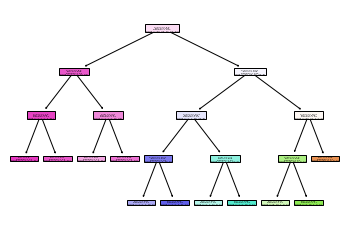

In [169]:
from sklearn import tree
import pydotplus 
from collections import defaultdict
import graphviz

# use the model train by K-Fold and five-level  
text_representation = tree.export_text(estimator)
print(text_representation)
tree.plot_tree(estimator,filled=True)


print("test data :",X_five_train_list[2][14,:]) # 1-sample

When a test data (for example : X_five_test_list[2]'s 15 row ) goes into the decision tree which is plot above, it will first check whether feature_14 (X[15]) is greater than 9.50, and will go down to the next level of the decision tree (for example in this case, the feature_14 > 9.5 therefore it will go down to the right leaf). Then, it will re-execute the process (the second level is split by feature_14 <=13.50 or > 13.5, in this case it will go down to the right leaf and down to class A because feature_14 > 15.5) until it reach the leaf. The leaf will specify which class is the data belongs to and that is the prediction by this decision tree.

## Random Forest : Describe the difference between boosting and bagging

Bagging: Randomly extract samples from the training data (take it out and put it back) to train multiple classifiers, and the ***weight of each classifier is the same***. Finally, using the voting method (Majority vote) to get the final result.
<br><br>

Boosting: First, for a piece of data, M models are established as a family(for example M decision trees are established). These models are relatively simple which are called weak learner. After testing data, we will put our focus on the wrong data that the weak learner did wrong and add more weights to those data then create another family and execute the process again. 

Difference : Bagging is mainly aim to decrease the variance by using multiple models, Boosting is an iterative technique which adjusts the weight of data based on the last classification (notice that it will also reduce variance).


## KNN

### Pick 2 features, draw and describe the KNN decision boundaries.

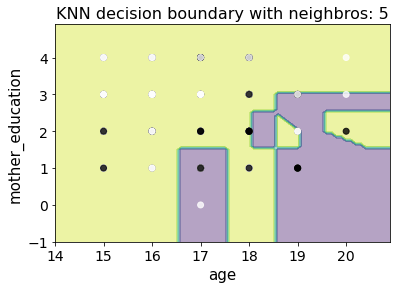

In [170]:
df_original['final_grade'] = '0'
df_original.loc[(df_original.final_score >= 10), 'final_grade'] = '1'
df_knn=df_original.drop(columns=['final_score'])


X_binary = df_knn.iloc[:,:32].values   
Y_binary = df_knn['final_grade'].values

# hold out splitting data into 70% training and 30% test data: 
# test_size is the ratio
X_binary_train, X_binary_test, y_binary_train, y_binary_test = train_test_split(X_binary, Y_binary, test_size=0.3, random_state=1) 
X_binary_train1 = X_binary_train[:,[2,6]]   # age

#X_binary_train1 = preprocessing.normalize(X_binary_train1)


import matplotlib.pyplot as plt

def plot_decision_boundaries(X, y, model_class, **model_params):
    
    reduced_data = X[:, :2]
    model = model_class(**model_params)
    model.fit(reduced_data, y)

    h = .02

    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    plt.xlabel("age",fontsize=15)
    plt.ylabel("mother_education",fontsize=15)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    return plt


plt.figure()
plt.title("KNN decision boundary with neighbros: 5",fontsize=16)
plot_decision_boundaries(X_binary_train1,y_binary_train, KNeighborsClassifier,n_neighbors=5)
plt.show()

#df_knn.head(10)

### code explain
```
X_binary_train1 = X_binary_train[:,[2,6]] #pick age and mother_education column to retrain the model 

reduced_data = X[:, :2] # Reduces to the first two columns of data
model = model_class(**model_params) # **model_params=n_neighboors
model.fit(reduced_data, y)  # fit the model

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].    

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1

# Meshgrid creation
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh using the model.
Z = model.predict(np.c_[xx.ravel(), yy.ravel()])    

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

# Predictions to obtain the classification results
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
```

### decribe the decision boundary
different color represent different binary class (fail and pass), the decision boundaries split data by location into two classes. However this KNN model is just train by two feature, the real KNN boundaries will be in multi-dimension and also split into two region (in binary class)

### Show the prediction and reasoning of 1-samples in the validation set.

In [171]:
# KNN first model 

X_norm_train = preprocessing.normalize(X_five_train)
X_norm_test = preprocessing.normalize(X_five_test)

X_norm_test = X_norm_test[0,0:]
neigh1.fit(X_norm_train,y_five_train)
distance, ind = neigh1.kneighbors(n_neighbors=5)
#print(X_norm_train[0])
print(distance)
print(ind)

[[0.1364073  0.15521163 0.1569752  0.16308343 0.17066576]
 [0.22789766 0.23796716 0.25167573 0.25673018 0.2623377 ]
 [0.12615428 0.13215374 0.14665271 0.15833516 0.16129864]
 ...
 [0.19643139 0.20456897 0.20491889 0.21126332 0.21256303]
 [0.16969668 0.21365639 0.23150218 0.24498197 0.24845154]
 [0.21934305 0.22935449 0.23939498 0.26922448 0.26976382]]
[[250 158  33 242 203]
 [241 207 172  20 249]
 [ 78  33 253  53 203]
 ...
 [219 232 247 119  74]
 [110 256 195 152 185]
 [ 50 135  92  62 217]]


We use the formula in Chapter3 p.28 ![title](picture.png)<br><br> 


According to the above two arrays, the distance array gives the K nearest distance between test data and K nodes. The indices indicates which K nodes are these. For example, the first row distance = ```[0.1364073  0.15521163 0.1569752  0.16308343 0.17066576] ```and indices =  ```[250 158  33 242 203] ```means that the distance between test data and node251(starts from zero index) is 0.1364073 ,and distance between test data and node159 is 0.15521163 and so on. (notice that the rows are for different test data)<br><br>
Next we are going to predict the pass or fail, first assume that ```[250 158  33 242 203] ```class = ```[pass,pass,fail,fail,pass] ```(the real class can be find in the dataset).Then, we caculate {1/pow(0.1364073,2) + 1/pow(0.15521163,2) + 0/pow(0.1569752,2) + 0/pow(0.16308343,2) + 1*pow(0.17066576,2)} / {pow(0.1364073,2) + pow(0.15521163,2) + pow(0.1569752,2) + pow(0.16308343,2) + pow(0.17066576,2)} and check if it is greater than 0.5. If yes, predict=pass, else predict=false. (I'm not going to caculate here, just writing down how it works, hope it is clear enough)


  